Step: <br>
    1. [Import dataset](#Import-Dataset)<br>
    2. [Data cleansing](#Data-Cleansing)<br>
    3. [Split dataset](#Split-Dataset)<br>
    4. [Modelling](#Modelling)<br>
    5. [Predict](#Predict)<br>

In [1]:
import pandas as pd
import string
import nltk
import time

### Import Dataset

In [2]:
#import dataset
dataset_columns = ["target", "ids", "date", "flag", "user", "text"]
dataset_encode = "ISO-8859-1"
data = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding = dataset_encode, names = dataset_columns)

In [3]:
data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Data Cleansing

In [4]:
data.drop(['ids','date','flag','user'],axis = 1,inplace = True)
print('Null values: ', data['text'].isnull().sum())

Null values:  0


In [5]:
data['target'].value_counts()

4    800000
0    800000
Name: target, dtype: int64

In [6]:
#remove punctuation
def remove_punctuation(text):
    no_punct=[words for words in text if words not in string.punctuation]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct
data['clean_text']=data['text'].apply(lambda x: remove_punctuation(x))
data.head()

,target,text,clean_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot httptwitpiccom2y1zl Awww thats a b...
1,0,is upset that he can't update his Facebook by ...,is upset that he cant update his Facebook by t...
2,0,@Kenichan I dived many times for the ball. Man...,Kenichan I dived many times for the ball Manag...
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....",nationwideclass no its not behaving at all im ...


In [7]:
import re
#remove hyperlink
data['clean_text'] = data['clean_text'].str.replace(r"http\S+", "") 
#remove emoji
data['clean_text'] = data['clean_text'].str.replace('[^\w\s#@/:%.,_-]', '', flags=re.UNICODE)
#convert all words to lowercase
data['clean_text'] = data['clean_text'].str.lower()
data.head()

,target,text,clean_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot awww thats a bummer you shoulda ...
1,0,is upset that he can't update his Facebook by ...,is upset that he cant update his facebook by t...
2,0,@Kenichan I dived many times for the ball. Man...,kenichan i dived many times for the ball manag...
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....",nationwideclass no its not behaving at all im ...


In [8]:
#tokenization
start = time.time()

nltk.download('punkt')
def tokenize(text):
    split=re.split("\W+",text) 
    return split
data['clean_text_tokenize']=data['clean_text'].apply(lambda x: tokenize(x.lower()))

end = time.time()
print('Elapsed time: ',end - start)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\laptop\anaconda3\lib\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Elapsed time:  19.735047340393066


In [9]:
#stopwords
start = time.time()

nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text=[word for word in text if word not in stopword]
    return text
data['clean_text_tokenize_stopwords'] = data['clean_text_tokenize'].apply(lambda x: remove_stopwords(x))
data.head(10)

end = time.time()
print('Elapsed time: ',end - start)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laptop\anaconda3\lib\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Elapsed time:  62.60138463973999


### Split Dataset

In [10]:
# store label and text into new dataframe
new_data = pd.DataFrame()
new_data['text'] = data['clean_text']
new_data['label'] = data['target']
new_data['label'] = new_data['label'].replace(4,1)

In [11]:
# 1 for positive, 0 for negative
print(new_data.head())
print('Label: \n', new_data['label'].value_counts())

                                                text  label
0  switchfoot   awww thats a bummer  you shoulda ...      0
1  is upset that he cant update his facebook by t...      0
2  kenichan i dived many times for the ball manag...      0
3    my whole body feels itchy and like its on fire       0
4  nationwideclass no its not behaving at all im ...      0
Label: 
 1    800000
0    800000
Name: label, dtype: int64


In [12]:
from sklearn.model_selection import train_test_split
X = new_data['text']
y = new_data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1520000,)
(80000,)
(1520000,)
(80000,)


In [13]:
y_train.value_counts()

0    760001
1    759999
Name: label, dtype: int64

### Modelling

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(analyzer = "word", ngram_range=(1,3)), MultinomialNB(alpha = 10))

In [15]:
start = time.time()

model.fit(X_train,y_train)

end = time.time()
print('Elapsed time: ',end - start)

Elapsed time:  226.94390320777893


In [16]:
validation = model.predict(X_test)

In [17]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, validation)

0.7963375

In [19]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, validation)
cf_matrix

array([[34905,  5094],
       [11199, 28802]], dtype=int64)

<AxesSubplot:>

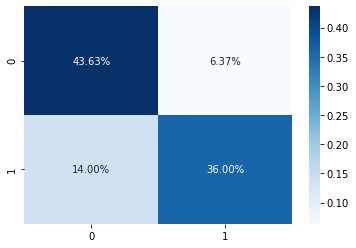

In [20]:
import seaborn as sns
import numpy as np
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_test, validation))

              precision    recall  f1-score   support

           0       0.76      0.87      0.81     39999
           1       0.85      0.72      0.78     40001

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



### Predict

In [22]:
train = pd.DataFrame()
train['label'] = y_train
train['text'] = X_train

def depression(s, model=model):
    pred = model.predict([s])
    predprob = model.predict_proba([s])
    if pred[0] == 1:
        return print('Not depressed\nProbability: ', np.max(predprob))
    else:
         return print('Depressed\nProbability: ', np.max(predprob))

In [23]:
depression('i love you')

Not depressed
Probability:  0.832918641698562


In [24]:
depression('i wanna kill myself')

Depressed
Probability:  0.6882493360091686


In [ ]:
#new_text = input('Input some text here: ')
#depression(new_text)

### Attempt using Support Vector Machine

In [45]:
start = time.time()

tf = TfidfVectorizer(analyzer = "word", ngram_range=(1,3))
word_freq = tf.fit_transform(X_train)

end = time.time()
print('Elapsed time: ',end - start)

Elapsed time:  228.49702954292297


In [ ]:
word_freq_df = pd.DataFrame(word_freq.toarray(), columns=tf.get_feature_names())
word_freq_df.head(10)

In [ ]:
word_list_tf = tf.get_feature_names()
count_list_tf = word_freq.toarray().sum(axis=0) 
word_freq_tf = dict(zip(word_list_tf,count_list_tf))
sorted(word_freq_tf.items(), key=lambda x: x[1], reverse=True)

In [ ]:
from sklearn import svm
start = time.time()

SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(word_freq, y_train)

end = time.time()
print('Elapsed time: ',end - start)
#model2 = make_pipeline(TfidfVectorizer(analyzer = "word", ngram_range=(1,3)), svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'))

In [ ]:
predictions_SVM = SVM.predict(X_test)
accuracy_score(y_test, predictions_SVM)

In [ ]:
accuracy_score(y_test, predictions_SVM)

In [ ]:
print('Run success!')